In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')
from finrl.config_tickers import DOW_30_TICKER,NAS_100_TICKER,HSI_50_TICKER,DAX_30_TICKER,SP_500_TICKER
import datetime
import seaborn as sns
import pickle
%matplotlib inline
from finrl.config_tickers import DOW_30_TICKER
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import data_split
from stock_env import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent,DRLEnsembleAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline,trx_plot
from feature_engineer import FeatureEngineer
from models import DRLAgent
from portfolio_optimization_env import PortfolioOptimizationEnv
from pprint import pprint
import scienceplots
import sys
from agents.evn_mvo import StockPortfolioEnv
from agents.mvo_agent import MarkowitzAgent
sys.path.append("../FinRL-Library")
import quantstats as qs
plt.style.use('science')
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)
from pypfopt import expected_returns

check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

def DRL_prediction(model, environment,time_window, deterministic=True):
    """make a prediction and get results"""
    test_env, test_obs = environment.get_sb_env()
    account_memory = None  # This help avoid unnecessary list creation
    actions_memory = None  # optimize memory consumption
    # state_memory=[] #add memory pool to store states

    test_env.reset()
    max_steps = len(environment._df.index.unique()) - time_window - 1

    for i in range(len(environment._df.index.unique())):
        action, _states = model.predict(test_obs, deterministic=deterministic)
        # account_memory = test_env.env_method(method_name="save_asset_memory")
        # actions_memory = test_env.env_method(method_name="save_action_memory")
        test_obs, rewards, dones, info = test_env.step(action)
        if i == max_steps:  # more descriptive condition for early termination to clarify the logic
            date_list = environment._date_memory
            portfolio_return = environment._portfolio_return_memory
            # print(len(date_list))
            # print(len(asset_list))
            df_account_value = pd.DataFrame(
                {"date": date_list, "daily_return": portfolio_return,'account' :  environment._asset_memory["final"],'weights':environment._final_weights}
            )
            df_date = pd.DataFrame(date_list)
            df_date.columns = ["date"]

            action_list = environment._actions_memory
            df_actions = pd.DataFrame(action_list)
            tiks = environment._tic_list
            df_actions.columns = np.insert(tiks,0,'POS')
            df_actions.index = df_date.date
            # df_actions = pd.DataFrame({'date':date_list,'actions':action_list})
            account_memory = df_account_value
            actions_memory = df_actions
        # add current state to state memory
        # state_memory=test_env.env_method(method_name="save_state_memory")

        if dones[0]:
            print("hit end!")
            break
    return account_memory, actions_memory,test_obs
TRAIN_START_DATE = '2000-01-01'
TRAIN_END_DATE = '2022-12-30'
TEST_START_DATE = '2023-01-01'
TEST_END_DATE = '2024-10-01'
from pandas import read_csv
from agents.evn_mvo import StockPortfolioEnv
from agents.mvo_agent import MarkowitzAgent

df_dow =read_csv('./data/dow.csv')
df_nasdaq =read_csv('./data/nasdaq.csv')
df_hsi = read_csv('./data/hsi.csv')
df_dax = read_csv('./data/dax.csv')
df_sp500 = read_csv('./data/sp500.csv')

In [2]:

INDICATORS = [
    "close_5_ema",
]
fe = FeatureEngineer(use_technical_indicator=False,
                     tech_indicator_list = INDICATORS,
                     use_turbulence=True,
                     user_defined_feature =True)

processed = fe.preprocess_data(df_dow)
processed = processed.fillna(0)
processed= processed.replace(np.inf,0)
train_data= data_split(processed, TRAIN_START_DATE, TRAIN_END_DATE)
test_data = data_split(processed, TEST_START_DATE, TEST_END_DATE)


Successfully added turbulence index
Successfully added user defined features


In [4]:
train_data.head(50)

,Unnamed: 0,date,open,high,low,close,volume,tic,day,turbulence,return
0,0,2010-01-04,7.622500,7.660714,7.585000,6.454506,493729600,AAPL,0,0.0,0.001729
0,1,2010-01-04,56.630001,57.869999,56.560001,40.915886,5277400,AMGN,0,0.0,0.001729
0,2,2010-01-04,40.810001,41.099998,40.389999,32.906181,6894300,AXP,0,0.0,0.001729
0,3,2010-01-04,55.720001,56.389999,54.799999,43.777546,6186700,BA,0,0.0,0.001729
0,4,2010-01-04,57.650002,59.189999,57.509998,40.027210,7325600,CAT,0,0.0,0.001729
0,5,2010-01-04,18.652500,18.882500,18.547501,18.622328,7906000,CRM,0,0.0,0.001729
0,6,2010-01-04,24.110001,24.840000,24.010000,16.475370,59853700,CSCO,0,0.0,0.001729
0,7,2010-01-04,78.199997,79.199997,78.160004,44.045532,10173800,CVX,0,0.0,0.001729
0,8,2010-01-04,32.500000,32.750000,31.870001,27.715311,13700400,DIS,0,0.0,0.001729
0,9,2010-01-04,170.050003,174.250000,169.509995,133.968140,9135000,GS,0,0.0,0.001729


In [192]:
test_data

,Unnamed: 0,date,open,high,low,close,volume,tic,day,turbulence,return
0,95843,2023-01-03,130.279999,130.899994,124.169998,123.904625,112117500,AAPL,1,50.305504,-0.037405
0,95844,2023-01-03,260.869995,262.600006,258.869995,247.431015,2594800,AMGN,1,50.305504,-0.003769
0,95845,2023-01-03,149.539993,150.449997,145.729996,143.260437,2762200,AXP,1,50.305504,-0.004264
0,95846,2023-01-03,192.949997,197.179993,192.399994,195.389999,8624600,BA,1,50.305504,0.025723
0,95847,2023-01-03,240.679993,240.679993,236.199997,231.220352,2651900,CAT,1,50.305504,-0.002839
...,...,...,...,...,...,...,...,...,...,...,...
437,108978,2024-09-30,583.500000,586.419983,578.739990,584.679993,3009700,UNH,0,15.215345,0.004864
437,108979,2024-09-30,275.000000,275.690002,273.200012,274.950012,5969900,V,0,15.215345,-0.000800
437,108980,2024-09-30,45.130001,45.360001,44.790001,44.219704,13509700,VZ,0,15.215345,0.000446
437,108981,2024-09-30,9.130000,9.290000,8.940000,8.960000,20239900,WBA,0,15.215345,-0.011038


In [4]:
def benchmark(train_data,test_data,data,iterations,t,features,INDICATORS):
    final_result = []
    models = [
        {'name': 'ppo', 'args': {
            "n_steps": 2048,
            "ent_coef": 0.01,
            "learning_rate": 0.0003,
            "batch_size": 128,
        }},
        {'name': 'a2c', 'args': None},
        # {'name': 'sac', 'args': None}
    ]
    env_kwargs = {
        "initial_amount": 100_0000,
        "normalize_df": None,
        "features": features,
        'comission_fee_pct': 0.001,
        'time_window': t
    }

    train_environment = PortfolioOptimizationEnv(df=train_data, **env_kwargs)
    test_environment = PortfolioOptimizationEnv(df=test_data, **env_kwargs)
    agent = DRLAgent(env=train_environment)
    for i, m in enumerate(models):
        result = {}
        model = agent.get_model(m['name'], model_kwargs=m['args'],tensorboard_log='./data/tb')
        ppo_model = agent.train_model(model=model,
                                        tb_log_name = m['name'],
                                        total_timesteps=iterations)
        training_summary = pd.DataFrame(
            {
                "date": train_environment._date_memory,
                "actions": train_environment._actions_memory,
                "weights": train_environment._final_weights,
                "returns": train_environment._portfolio_return_memory,
                "rewards": train_environment._portfolio_reward_memory,
                "portfolio_values": train_environment._asset_memory["final"],
            }
        )
        prediction_summary = DRL_prediction(ppo_model, test_environment, t)
        result["train"] = training_summary
        result["test"] = prediction_summary
        result["name"] = m['name']
        final_result.append(result)
    df = data.sort_values(['date', 'tic'], ignore_index=True)
    df.index = df.date.factorize()[0]
    cov_list = []
    mu= []
    # look back is one year
    lookback = 252
    for i in range(lookback, len(df.index.unique())):
        data_lookback = df.loc[i-lookback:i, :]
        price_lookback = data_lookback.pivot_table(
            index='date', columns='tic', values='close')
        return_lookback = price_lookback.pct_change().dropna()
        covs = return_lookback.cov().values
        mu.append(expected_returns.mean_historical_return(price_lookback))
        cov_list.append(covs)
    df_cov = pd.DataFrame(
    {'time': df.date.unique()[lookback:], 'cov_list': cov_list,'returns':mu})
    df = df.merge(df_cov, left_on='date',right_on='time')

    test_df = data_split(
    df,
    start=TEST_START_DATE,
    end=TEST_END_DATE
    )
    stock_dimension = len(test_df.tic.unique())
    state_space = stock_dimension

    result = {}

    env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "transaction_cost_pct": 0.001,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4

    }
    e_test_gym = StockPortfolioEnv(df=test_df, **env_kwargs)
    agent = MarkowitzAgent(e_test_gym)
    mvo_min_variance = agent.prediction(e_test_gym)
    mvo_min_variance["method"] = "markowitz"
    mvo_min_variance.columns = ['date','account','return','method']
    result["test"] = [mvo_min_variance]
    result["name"] = 'Min Variance Portfolio'
    final_result.append(result)


    result = {}
    env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "transaction_cost_pct": 0.001,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4

    }
    
    e_test_gym = StockPortfolioEnv(df=test_df, **env_kwargs)
    agent = MarkowitzAgent(e_test_gym,objective='sharpe')
    mvo_max_sharpe = agent.prediction(e_test_gym)
    mvo_max_sharpe["method"] = "markowitz"
    mvo_max_sharpe.columns = ['date','account','return','method']
    result["test"] = [mvo_max_sharpe]
    result["name"] = 'Max Sharpe Ratio'
    final_result.append(result)
    return final_result

In [189]:
result = benchmark(train_data,test_data,df_dow,50_000,1,['close','return'],INDICATORS)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.0003, 'batch_size': 128}
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./data/tb\ppo_10
-------------------------------------
| time/              |              |
|    fps             | 23           |
|    iterations      | 1            |
|    time_elapsed    | 88           |
|    total_timesteps | 2048         |
| train/             |              |
|    reward          | 0.0030327304 |
-------------------------------------
Initial portfolio value:1000000
Final portfolio value: 1255858.0
Final accumulative portfolio value: 1.255858
Maximum DrawDown: -0.3397388680272315
Sharpe ratio: 0.18903766405125524
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 3.27e+03    |
|    ep_rew_mean          | 0.239       |
| time/                   |             |
|    fps                  | 22          |
|    iterations      

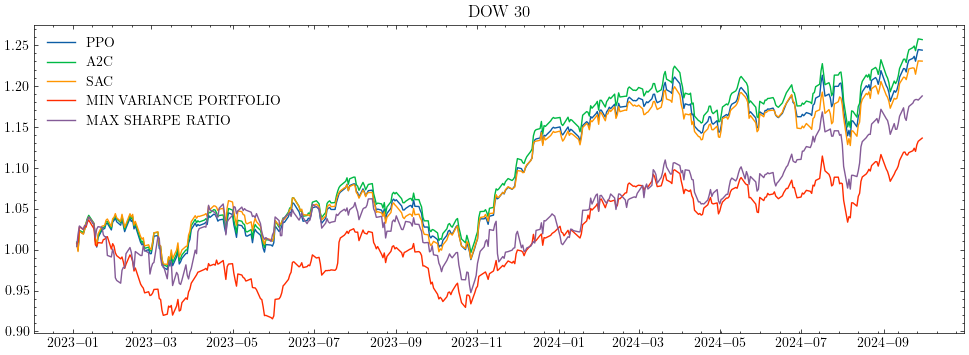

In [190]:
with plt.style.context('science','ieee'):
    plt.figure(figsize=(12,4))
    for i,item in enumerate(result): 
            plt.plot(item['test'][0].get('date'),(item['test'][0].get('account').pct_change()+ 1 ).cumprod(),label=str(item['name']).upper())
    plt.legend()
    plt.title('DOW 30')
    plt.show()


In [191]:
with open('./models/dow.pkl','wb') as f:
    pickle.dump(result,f)

In [193]:
result = benchmark(train_data,test_data,df_dow,50_000,1,['close','return','turbulence'],INDICATORS)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.0003, 'batch_size': 128}
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./data/tb\ppo_11
-------------------------------------
| time/              |              |
|    fps             | 11           |
|    iterations      | 1            |
|    time_elapsed    | 183          |
|    total_timesteps | 2048         |
| train/             |              |
|    reward          | 0.0011666167 |
-------------------------------------
Initial portfolio value:1000000
Final portfolio value: 1283474.625
Final accumulative portfolio value: 1.283474625
Maximum DrawDown: -0.3617770674615598
Sharpe ratio: 0.19917308893094926
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 3.27e+03    |
|    ep_rew_mean          | 0.261       |
| time/                   |             |
|    fps                  | 10          |
|    iterations 

In [194]:
with open('./models/dow_tubulance.pkl','wb') as f:
    pickle.dump(result,f)

In [5]:
INDICATORS = [
    "close_5_ema",
]
fe = FeatureEngineer(use_technical_indicator=False,
                     tech_indicator_list = INDICATORS,
                     use_turbulence=True,
                     user_defined_feature =True)

processed = fe.preprocess_data(df_dax)
processed = processed.fillna(0)
processed= processed.replace(np.inf,0)
train_data= data_split(processed, TRAIN_START_DATE, TRAIN_END_DATE)
test_data = data_split(processed, TEST_START_DATE, TEST_END_DATE)



Successfully added turbulence index
Successfully added user defined features


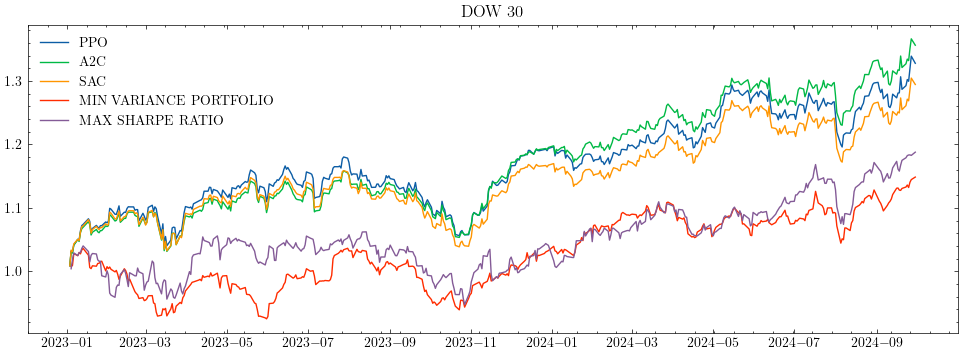

In [ ]:
with plt.style.context('science','ieee'):
    plt.figure(figsize=(12,4))
    for i,item in enumerate(result): 
            plt.plot(item['test'][0].get('date'),(item['test'][0].get('account').pct_change()+ 1 ).cumprod(),label=str(item['name']).upper())
    plt.legend()
    plt.title('DOW 30')
    plt.show()


In [197]:
train_data


,Unnamed: 0,date,open,high,low,close,volume,tic,day,turbulence,return
0,0,2010-01-04,37.959999,38.525002,37.685001,31.563416,953276,ADS.DE,0,0.000000,0.031554
0,1,2010-01-04,87.800003,88.889999,87.599998,43.213936,1676777,ALV.DE,0,0.000000,0.031554
0,2,2010-01-04,43.459999,44.849998,43.349998,22.495085,3245626,BAS.DE,0,0.000000,0.031554
0,3,2010-01-04,55.315983,55.808029,54.863300,36.101337,2251520,BAYN.DE,0,0.000000,0.031554
0,4,2010-01-04,45.849998,46.619999,45.799999,40.290047,336203,BEI.DE,0,0.000000,0.031554
...,...,...,...,...,...,...,...,...,...,...,...
3300,88158,2022-12-29,303.000000,305.899994,302.500000,284.934357,133667,MUV2.DE,3,5.556788,0.006912
3300,88159,2022-12-29,41.240002,41.910000,41.169998,39.606857,965815,RWE.DE,3,5.556788,0.010656
3300,88160,2022-12-29,96.500000,97.769997,96.290001,94.755440,859679,SAP.DE,3,5.556788,0.009517
3300,88161,2022-12-29,127.900002,130.460007,127.800003,123.221603,637451,SIE.DE,3,5.556788,0.015730


In [204]:
result = benchmark(train_data,test_data,df_dax,30_000,1,['close','return'],INDICATORS)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.0003, 'batch_size': 128}
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./data/tb\ppo_15
------------------------------------
| time/              |             |
|    fps             | 22          |
|    iterations      | 1           |
|    time_elapsed    | 92          |
|    total_timesteps | 2048        |
| train/             |             |
|    reward          | 0.005797713 |
------------------------------------
Initial portfolio value:1000000
Final portfolio value: 759570.5
Final accumulative portfolio value: 0.7595705
Maximum DrawDown: -0.5131270104407779
Sharpe ratio: -0.023530802405723642
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 3.3e+03      |
|    ep_rew_mean          | -0.265       |
| time/                   |              |
|    fps                  | 20           |
|    iterations       

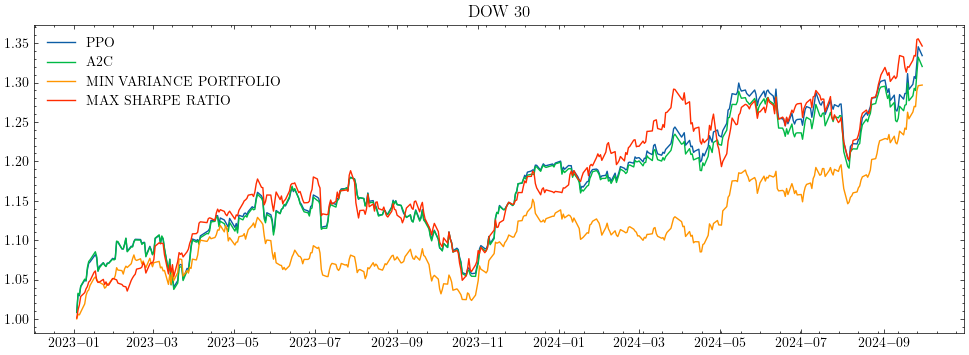

In [205]:
with plt.style.context('science','ieee'):
    plt.figure(figsize=(12,4))
    for i,item in enumerate(result): 
            plt.plot(item['test'][0].get('date'),(item['test'][0].get('account').pct_change()+ 1 ).cumprod(),label=str(item['name']).upper())
    plt.legend()
    plt.title('DOW 30')
    plt.show()


In [6]:
result = benchmark(train_data,test_data,df_dax,50_000,1,['close','return','turbulence'],INDICATORS)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.0003, 'batch_size': 128}
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./data/tb\ppo_18
-------------------------------------
| time/              |              |
|    fps             | 45           |
|    iterations      | 1            |
|    time_elapsed    | 45           |
|    total_timesteps | 2048         |
| train/             |              |
|    reward          | 0.0067834333 |
-------------------------------------
Initial portfolio value:1000000
Final portfolio value: 855530.125
Final accumulative portfolio value: 0.855530125
Maximum DrawDown: -0.5072779582267422
Sharpe ratio: 0.025317438834733474
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 3.3e+03     |
|    ep_rew_mean          | -0.147      |
| time/                   |             |
|    fps                  | 42          |
|    iterations 

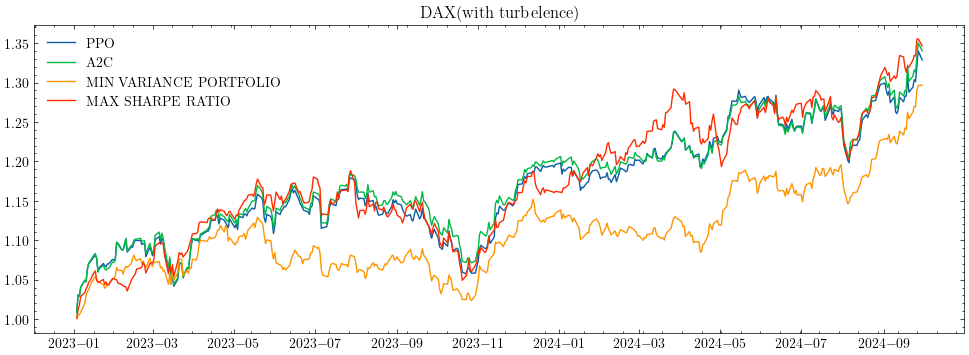

In [12]:
%matplotlib inline

with plt.style.context('science','ieee'):
    plt.figure(figsize=(12,4))
    for i,item in enumerate(result): 
            plt.plot(item['test'][0].get('date'),(item['test'][0].get('account').pct_change()+ 1 ).cumprod(),label=str(item['name']).upper())
    plt.legend()
    plt.title('DAX(with turbelence)')
    plt.show()


In [ ]:
result = benchmark(train_data,test_data,df_dax,50_000,1,['close','return'],INDICATORS)

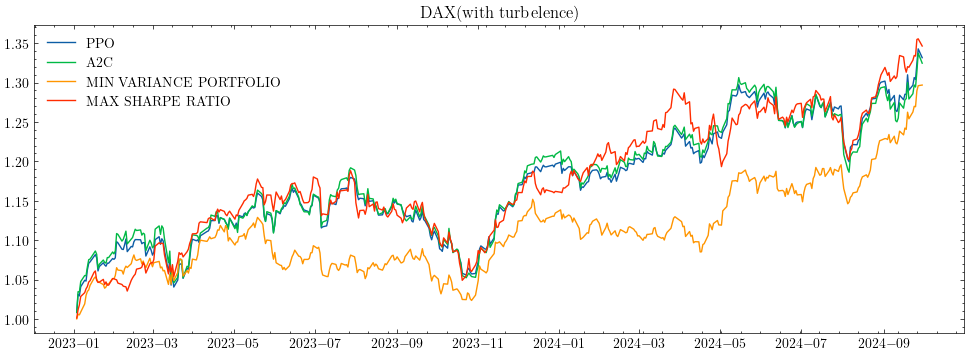

In [14]:
%matplotlib inline

with plt.style.context('science','ieee'):
    plt.figure(figsize=(12,4))
    for i,item in enumerate(result): 
            plt.plot(item['test'][0].get('date'),(item['test'][0].get('account').pct_change()+ 1 ).cumprod(),label=str(item['name']).upper())
    plt.legend()
    plt.title('DAX(with turbelence)')
    plt.show()


In [ ]:
INDICATORS = [
    "close_5_ema",
]
fe = FeatureEngineer(use_technical_indicator=False,
                     tech_indicator_list = INDICATORS,
                     use_turbulence=True,
                     use_vix= True,
                     user_defined_feature =True)

processed = fe.preprocess_data(df_dax)
processed = processed.fillna(0)
processed= processed.replace(np.inf,0)
train_data= data_split(processed, TRAIN_START_DATE, TRAIN_END_DATE)
test_data = data_split(processed, TEST_START_DATE, TEST_END_DATE)




[*********************100%%**********************]  1 of 1 completed


Shape of DataFrame:  (3709, 8)
Successfully added vix
Successfully added turbulence index
Successfully added user defined features


In [17]:
result = benchmark(train_data,test_data,df_dax,50_000,1,['close','return','vix'],INDICATORS)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.0003, 'batch_size': 128}
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./data/tb\ppo_20
-------------------------------------
| time/              |              |
|    fps             | 46           |
|    iterations      | 1            |
|    time_elapsed    | 44           |
|    total_timesteps | 2048         |
| train/             |              |
|    reward          | -0.006264419 |
-------------------------------------
Initial portfolio value:1000000
Final portfolio value: 779381.75
Final accumulative portfolio value: 0.77938175
Maximum DrawDown: -0.5359139710397471
Sharpe ratio: -0.014343057577075968
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 3.22e+03      |
|    ep_rew_mean          | -0.239        |
| time/                   |               |
|    fps                  | 43            |
|    

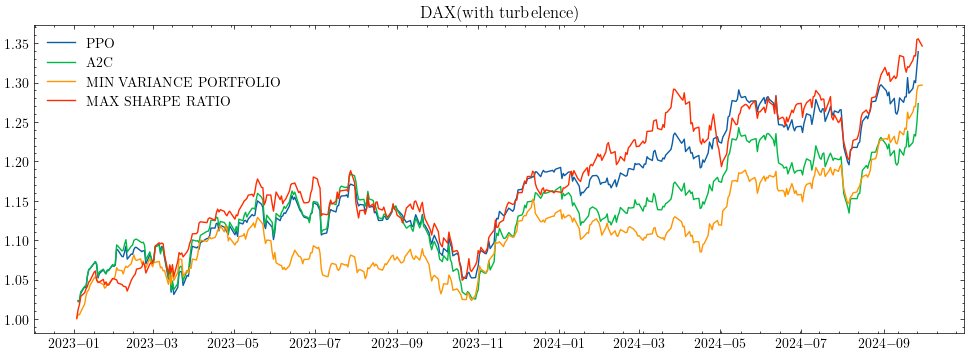

In [19]:
%matplotlib inline

with plt.style.context('science','ieee'):
    plt.figure(figsize=(12,4))
    for i,item in enumerate(result): 
            plt.plot(item['test'][0].get('date'),(item['test'][0].get('account').pct_change()+ 1 ).cumprod(),label=str(item['name']).upper())
    plt.legend()
    plt.title('DAX(with turbelence)')
    plt.show()


In [ ]:
resultzzz = benchmark(train_data,test_data,50_000,1,['close','return','vix','turbulence'],INDICATORS)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.0003, 'batch_size': 128}
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./data/tb\ppo_21
--------------------------------------
| time/              |               |
|    fps             | 44            |
|    iterations      | 1             |
|    time_elapsed    | 45            |
|    total_timesteps | 2048          |
| train/             |               |
|    reward          | -0.0074967304 |
--------------------------------------
Initial portfolio value:1000000
Final portfolio value: 697013.0
Final accumulative portfolio value: 0.697013
Maximum DrawDown: -0.5166362999212288
Sharpe ratio: -0.06123990776584326
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 3.22e+03      |
|    ep_rew_mean          | -0.351        |
| time/                   |               |
|    fps                  | 42            |


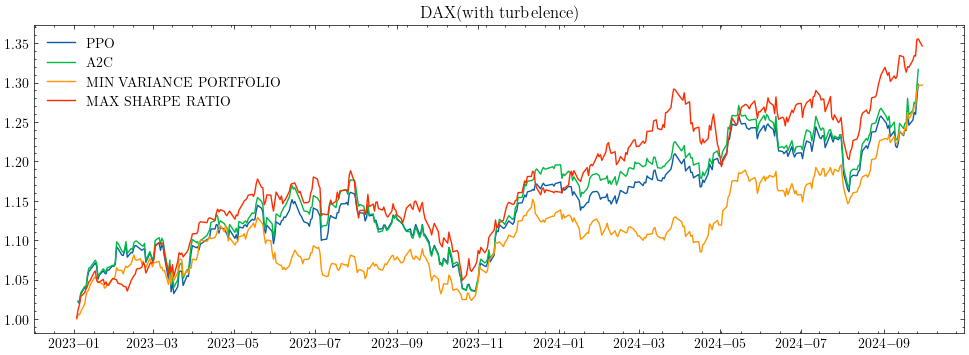

In [20]:
%matplotlib inline

with plt.style.context('science','ieee'):
    plt.figure(figsize=(12,4))
    for i,item in enumerate(resultzzz): 
            plt.plot(item['test'][0].get('date'),(item['test'][0].get('account').pct_change()+ 1 ).cumprod(),label=str(item['name']).upper())
    plt.legend()
    plt.title('DAX(with turbelence)')
    plt.show()
